# Using `maup` to use a real-life plan in GerryChain

To generate an ensemble of districting plans using GerryChain, we need a starting point for our Markov chain. GerryChain gives you functions like `recursive_tree_part` to generate such plans from scratch, but you may want to use an actual districting plan from the real world instead. You also may want to compare a real-life plan to your ensemble.

[`maup`](https://github.com/mggg/maup) is MGGG's package for doing common spatial data operations with redistricting data. We'll use this package to assign our basic geographic units to the districts in the plan we're interested in. Our steps are:

- Download a Shapefile of the districting plan we're interested in,
- Use `maup` to assign the our basic units to the districts in that plan, and then
- Create a GerryChain Partition using that assignment.

In [17]:
import maup
import geopandas
import matplotlib.pyplot as plt

## Downloading a plan

For this guide, we'll assign Massachusetts's block groups to the 2010 Massachusetts State Senate districting plan.
We can use [geopandas](https://geopandas.org) to download this Shapefile straight from the TIGER/Line files on the U.S. Census Bureau's website:

In [2]:
districts = geopandas.read_file("https://www2.census.gov/geo/tiger/TIGER2012/SLDU/tl_2012_25_sldu.zip")

## Getting the assignment

Now we can use `maup` to assign our units to districts. See [the `maup` documentation](https://github.com/mggg/maup/blob/master/README.md#assigning-precincts-to-districts) for another example and more information.

First we'll load our units as a GeoDataFrame:

In [3]:
units = geopandas.read_file("zip://./BG25.zip")

Now we'll use `maup.assign` to get an assignment from units to districts:

In [4]:
assignment = maup.assign(units, districts)

TypeError: the source and target geometries must have the same CRS. {'proj': 'aea', 'lat_1': 29.5, 'lat_2': 45.5, 'lat_0': 37.5, 'lon_0': -96, 'x_0': 0, 'y_0': 0, 'ellps': 'GRS80', 'units': 'm', 'no_defs': True} {'init': 'epsg:4269'}

Oh no! ❌ This error is telling us that the coordinates in our `units` and our `districts` are stored in different coordinate reference systems (different projections). We can fix this by setting the `units` CRS to match the `districts` CRS:

In [40]:
units.to_crs(districts.crs, inplace=True)

Now let's try again:

In [8]:
assignment = maup.assign(units, districts)

Yay! 🎉 It worked!

Let's use the [pandas](http://pandas.pydata.org/) `.isna()` method to see if we have any units that could not be assigned to districts:

In [9]:
assignment.isna().sum()

0

This means that every unit was successfully assigned. If our basic units were too large to get a meaningful assignment, or if the districts did not cover all of our units (e.g. if our units included parts of the Atlantic Ocean but the districts did not), then we would have units with NA assignments that we would need to make decisions about.

We'll save the assignment in a column of our `units` GeoDataFrame:

In [10]:
units["SENDIST"] = assignment

## Creating a GerryChain Partition with the real-life assignment

Now we are ready to use this assignment in GerryChain. We'll start by loading in our Graph from a pre-saved JSON file:

In [12]:
from gerrychain import Graph, Partition

graph = Graph.from_json("./Block_Groups/BG25.json")

In order to get this assignment onto the graph, we need to match the nodes of our graph to the geometries in `units` by their GEOIDs. We can use the `graph` object's `.join()` method to do this matching automatically:

In [13]:
graph.join(units, columns=["SENDIST"], left_index="GEOID10", right_index="GEOID10")

The `left_index` and `right_index` arguments tell the `.join()` method to use the `GEOID10` node attribute and the `GEOID10` column of `units` to match the records in `units` to the nodes of our graph.

Now `graph` has a node attribute called `SENDIST` that we can use to create a Partition:

In [41]:
real_life_plan = Partition(graph, "SENDIST")

To check our work, let's plot the `real_life_plan` using the Partition's `.plot()` method:

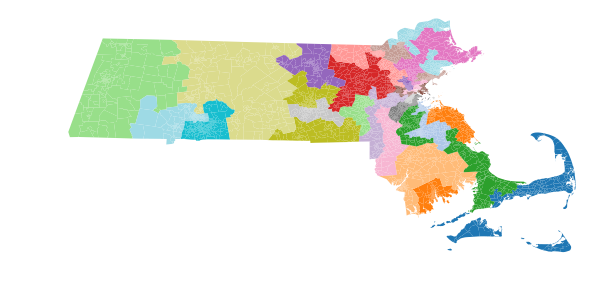

In [39]:
real_life_plan.plot(units, figsize=(10, 10), cmap="tab20")
plt.axis('off')
plt.show()

That looks like a districting plan! Woohoo! 🎉🎉🎉

### Troubleshooting possible issues

If the plan looked like random noise or confetti, then we might suspect that something had gone wrong. The two places we would want to look for problems would be:

- the `graph.join` call, which would go wrong if the GEOIDs did not match up correctly, or
- the final `real_life_plan.plot` call, which would go wrong if the GeoDataFrame's index did not match the node IDs of our graph in the right way.

We could inspect both issues by making sure that the records with matching IDs actually referred to the same block groups.

You also might run into problems when you go to run a Markov chain using the partition we made. If the districts are not contiguous with respect to your underlying graph, you would want to add edges (within reason) to make the graph agree with the notion of contiguity that the real-life plan uses. See [What to do about islands and connectivity](https://github.com/vrdi/Intro_Notebooks/blob/master/IslandsAndConnectivity.ipynb) for a guide to handling those types of issues.